In [2]:
import gzip
import csv
import json
import math
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Read Data
[Original Paper](https://cseweb.ucsd.edu/~jmcauley/pdfs/recsys21b.pdf)

In [3]:
def readCSV(path):
    f = gzip.open(path, 'rt')
    header = ['user_id', 'stream_id', 'stream_username', 'time_start', 'time_stop']
    for l in f:
        d = dict(zip(header,l.strip().split(',')))
        if int(d['user_id']) > 1_000_000:
            break
        else:
            yield d

In [4]:
# full = list(readCSV('data/full_a.csv.gz'))
# len(full)

In [5]:
# read benchmark
twitch_x = pd.read_csv(
    'data/100k_a.csv', 
    names=['user_id', 'stream_id', 'stream_username', 'time_start', 'time_stop'],
    dtype={'user_id': str, 'stream_id': str}
)

print(twitch_x.shape[0])

3051733


In [6]:
# add watch time
def add_watch_time(df, col):
    # process to minutes
    df[col + '_in_day'] = df[col] % 144
    df[col + '_at_day'] = df[col] // 144

add_watch_time(twitch_x, 'time_start')
add_watch_time(twitch_x, 'time_stop')
twitch_x['watch_time'] = twitch_x['time_stop'] - twitch_x['time_start']

In [6]:
twitch_x.head(15)

,user_id,stream_id,stream_username,time_start,time_stop,time_start_in_day,time_start_at_day,time_stop_in_day,time_stop_at_day,watch_time
0,1,33842865744,mithrain,154,156,10,1,12,1,2
1,1,33846768288,alptv,166,169,22,1,25,1,3
2,1,33886469056,mithrain,587,588,11,4,12,4,1
3,1,33887624992,wtcn,589,591,13,4,15,4,2
4,1,33890145056,jrokezftw,591,594,15,4,18,4,3
5,1,33903958784,berkriptepe,734,737,14,5,17,5,3
6,1,33929318864,kendinemuzisyen,1021,1036,13,7,28,7,15
7,1,33942837056,wtcn,1165,1167,13,8,15,8,2
8,1,33955351648,kendinemuzisyen,1295,1297,143,8,1,9,2
9,1,34060922080,mithrain,2458,2459,10,17,11,17,1


### Per-Stream Information

In [7]:
counts_per_stream = twitch_x['stream_id'].value_counts()

In [8]:
counts_per_stream.describe()

count    739991.000000
mean          4.124014
std          20.930964
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2123.000000
Name: stream_id, dtype: float64

Text(0.5, 1.0, 'Number of Streams Watched (> 400)')

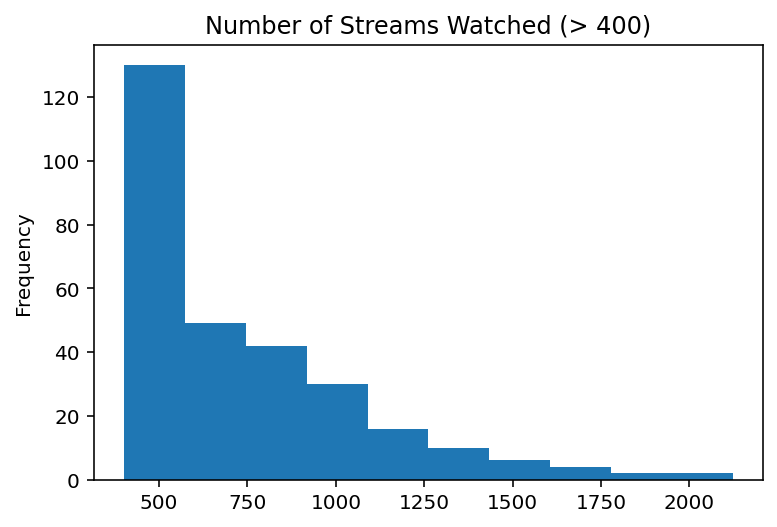

In [12]:
counts_per_stream[counts_per_stream > 400].plot(kind='hist')
plt.title('Number of Streams Watched (> 400)')

<AxesSubplot:ylabel='Frequency'>

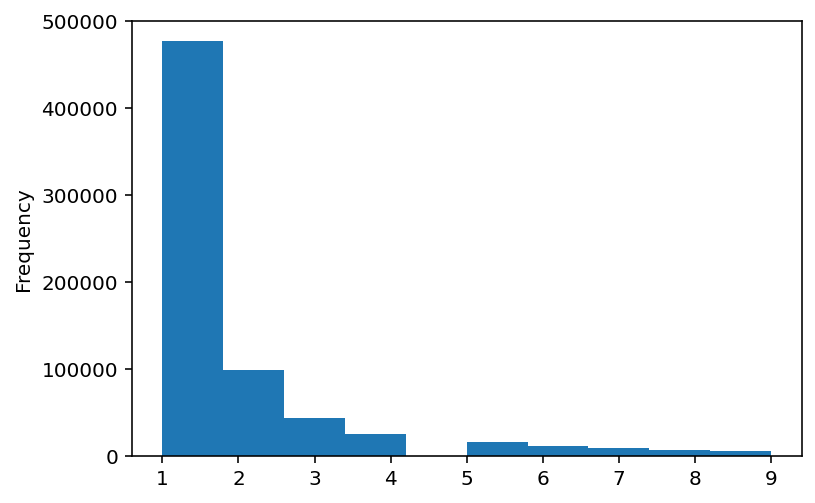

In [10]:
counts_per_stream[counts_per_stream < 10].plot(kind='hist')

In [11]:
users_per_stream = twitch_x.groupby('stream_id')['user_id'].agg(lambda s: set(s)).to_dict()

In [12]:
# stream-ID vs Streamer
ninja_100 = twitch_x.query('stream_username == \'ninja\'').sort_values(by='time_start')
ninja_100

,user_id,stream_id,stream_username,time_start,time_stop,time_start_in_day,time_start_at_day,time_stop_in_day,time_stop_at_day,watch_time
2642919,86973,33847384336,ninja,170,171,26,1,27,1,1
2939100,96304,33847384336,ninja,170,172,26,1,28,1,2
1616972,53392,33847384336,ninja,170,171,26,1,27,1,1
2799127,92007,33847384336,ninja,170,171,26,1,27,1,1
1937766,64095,33847384336,ninja,170,173,26,1,29,1,3
...,...,...,...,...,...,...,...,...,...,...
345273,11695,34401244464,ninja,6071,6072,23,42,24,42,1
754700,24967,34401244464,ninja,6071,6072,23,42,24,42,1
1916888,63400,34401244464,ninja,6071,6072,23,42,24,42,1
2251612,74222,34401244464,ninja,6071,6072,23,42,24,42,1


In [13]:
# user's repeated consumption on ONE stream
any(ninja_100.groupby('stream_id').get_group('34401244464').groupby('user_id')['stream_id'].count() > 1)

False

<AxesSubplot:title={'center':'Time Interactions Start In Day'}>

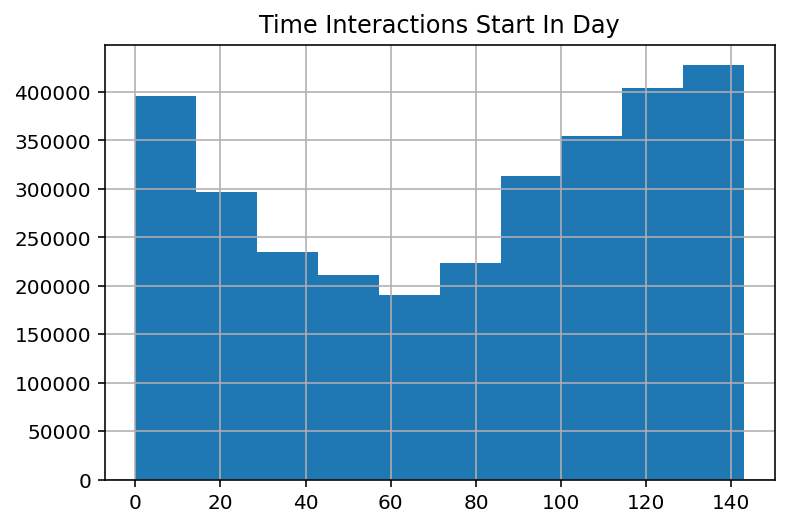

In [8]:
# time of stream
plt.title('Time Interactions Start In Day')
twitch_x['time_start_in_day'].hist()

<AxesSubplot:>

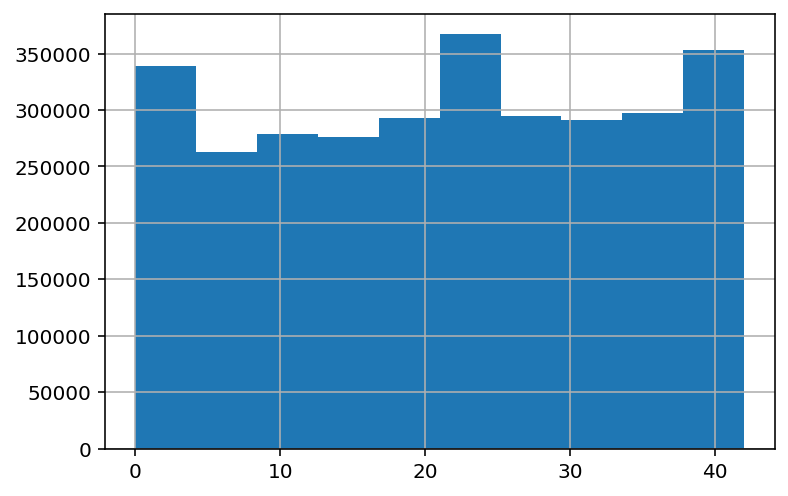

In [15]:
twitch_x['time_start_at_day'].hist()

Not using `stream_id` for this prediction task.

### Streamer Information

In [16]:
count_per_streamer = twitch_x['stream_username'].value_counts().sort_values(ascending=False)

In [17]:
count_per_streamer.describe()

count    162625.000000
mean         18.765460
std         251.414758
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max       45144.000000
Name: stream_username, dtype: float64

In [18]:
count_per_streamer

ninja         45144
tfue          40136
shroud        27362
riotgames     17633
sodapoppin    14590
              ...  
pafosnyi          1
swampnugg         1
onurke            1
jace_bong         1
fir3333           1
Name: stream_username, Length: 162625, dtype: int64

<AxesSubplot:ylabel='Frequency'>

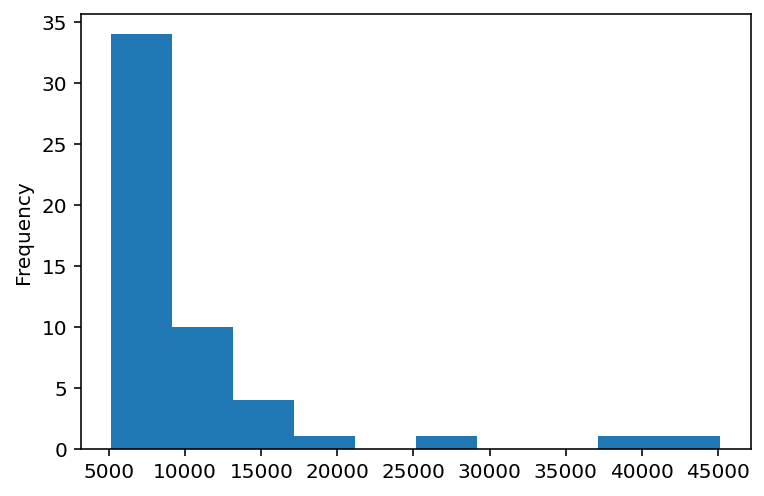

In [19]:
count_per_streamer[count_per_streamer > 5000].plot(kind='hist')

<AxesSubplot:>

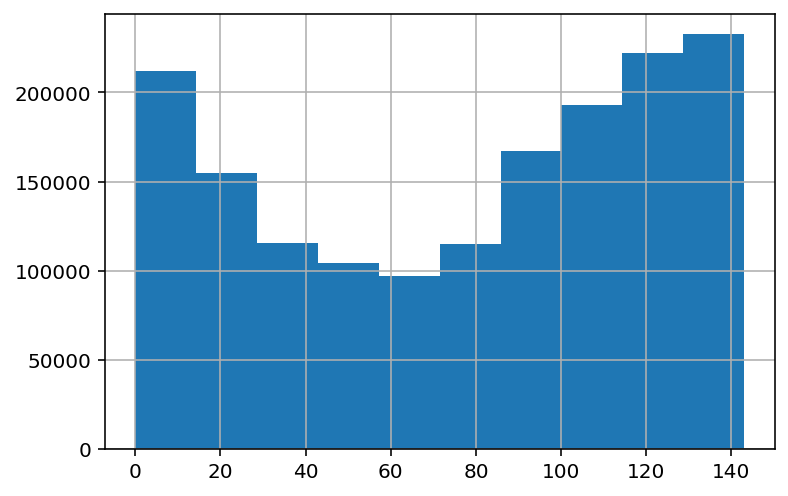

In [20]:
# time of top streamers
twitch_x[twitch_x['stream_username'].isin(count_per_streamer.iloc[:1000].index)]['time_start_in_day'].hist()

<AxesSubplot:>

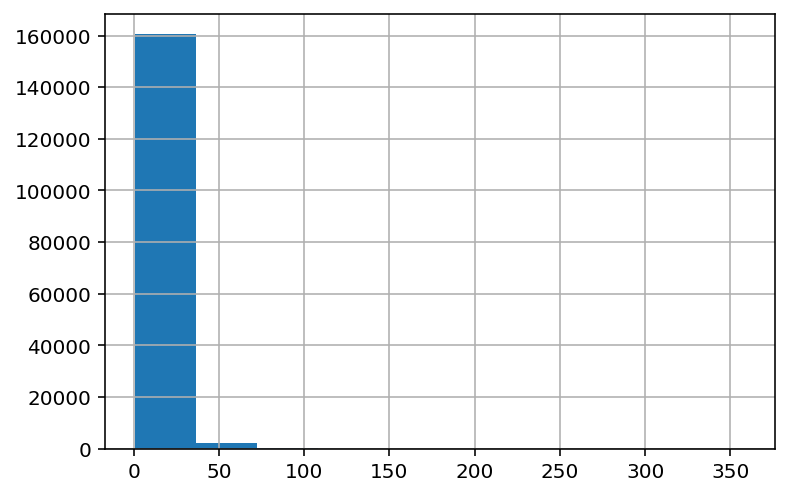

In [21]:
# number of streams
twitch_x.groupby('stream_username')['stream_id'].nunique().hist()

In [22]:
# multiple per day?
twitch_x.query("stream_username == 'luke4316live'").sort_values('stream_id')

,user_id,stream_id,stream_username,time_start,time_stop,time_start_in_day,time_start_at_day,time_stop_in_day,time_stop_at_day,watch_time
2900059,95139,33829809216,luke4316live,26,28,26,0,28,0,2
144030,5010,33829809216,luke4316live,32,33,32,0,33,0,1
1904009,62967,33829809216,luke4316live,6,9,6,0,9,0,3
167230,5792,33829809216,luke4316live,13,14,13,0,14,0,1
1736284,57381,33829809216,luke4316live,39,41,39,0,41,0,2
...,...,...,...,...,...,...,...,...,...,...
2641454,86926,34414032976,luke4316live,6124,6135,76,42,87,42,11
2641455,86926,34415000272,luke4316live,6135,6146,87,42,98,42,11
2183827,72039,34415000272,luke4316live,6145,6146,97,42,98,42,1
359274,12212,34415000272,luke4316live,6145,6146,97,42,98,42,1


In [23]:
# record if the user had watched before, might be insufficient
users_per_streamer = twitch_x.groupby('stream_username')['user_id'].agg(lambda s: set(s)).to_dict()

In [24]:
# users_per_streamer

In [25]:
# # find number of time watched
# twitch_x.pivot_table(
#     index='stream_username',
#     columns='user_id',
#     aggfunc='count',
#     fill_value=0
# )

### Per-User Information

In [26]:
time_per_user = twitch_x.groupby('user_id')['watch_time'].sum()

In [27]:
time_per_user.describe()

count    100000.000000
mean         95.887110
std         127.872463
min           5.000000
25%          19.000000
50%          45.000000
75%         116.000000
max        1438.000000
Name: watch_time, dtype: float64

<AxesSubplot:ylabel='Frequency'>

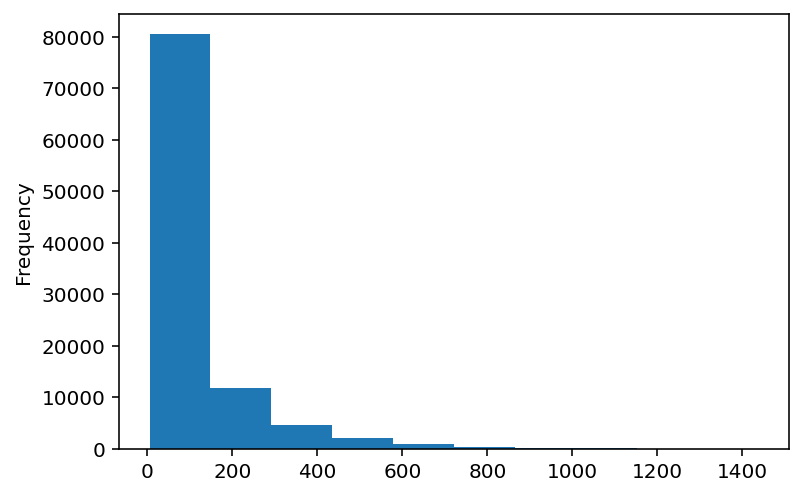

In [28]:
time_per_user.plot(kind='hist')

In [29]:
counts_per_user = twitch_x['user_id'].value_counts()

<AxesSubplot:ylabel='Frequency'>

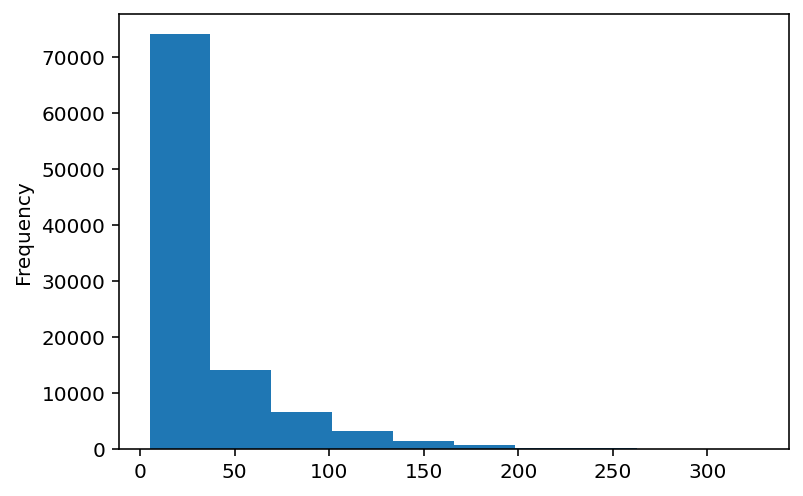

In [30]:
counts_per_user.plot(kind='hist')

In [31]:
# streamers per user
count_streamers_per_user = twitch_x.groupby('user_id')['stream_username'].nunique().sort_values(ascending=False)
count_streamers_per_user

user_id
43043    295
50084    198
58337    197
15026    196
14727    196
        ... 
30191      1
82336      1
82323      1
66551      1
18593      1
Name: stream_username, Length: 100000, dtype: int64

<AxesSubplot:xlabel='stream_username', ylabel='watch_time'>

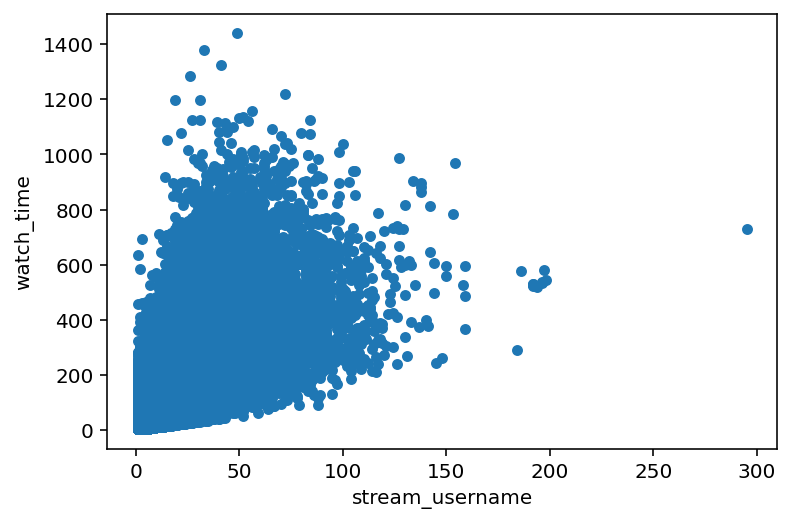

In [32]:
time_and_streamers = time_per_user.to_frame().join(count_streamers_per_user).sort_index(key=lambda i: i.astype(int))
time_and_streamers.plot(kind='scatter', x='stream_username', y='watch_time')

<AxesSubplot:xlabel='stream_username', ylabel='watch_time'>

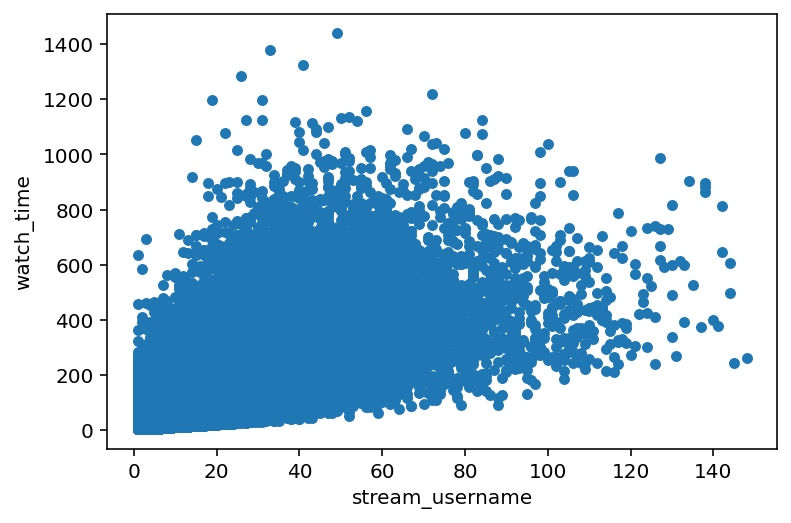

In [33]:
time_and_streamers.query("stream_username < 150").plot(kind='scatter', x='stream_username', y='watch_time')

<AxesSubplot:xlabel='user_id', ylabel='watch_time'>

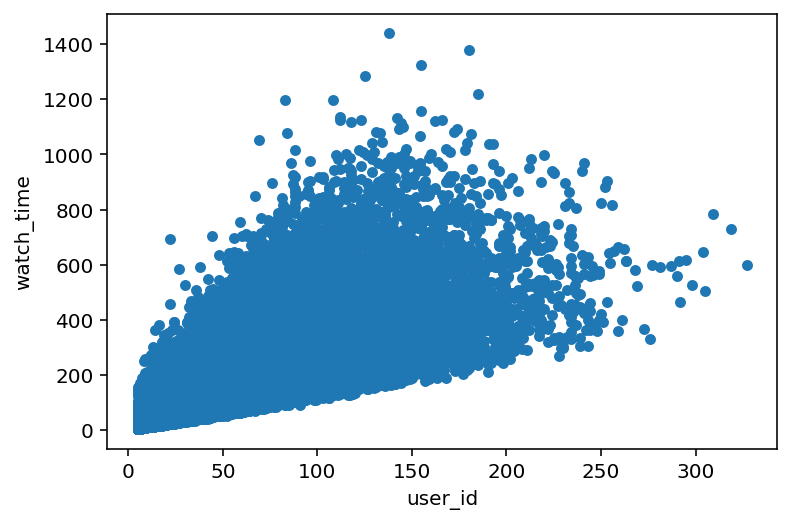

In [34]:
time_and_streams = time_per_user.to_frame().join(counts_per_user).sort_index(key=lambda i: i.astype(int))
time_and_streams.plot(kind='scatter', x='user_id', y='watch_time')

<AxesSubplot:title={'center':'Average Watch Time'}>

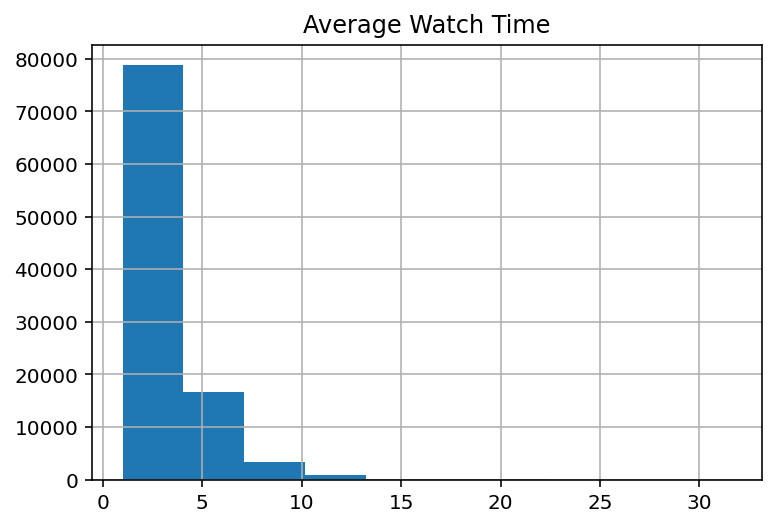

In [7]:
# average watch time
plt.title('Average Watch Time')
avg_watch_time = twitch_x.groupby('user_id')['watch_time'].mean()
avg_watch_time.hist()

<AxesSubplot:xlabel='stream_username', ylabel='watch_time'>

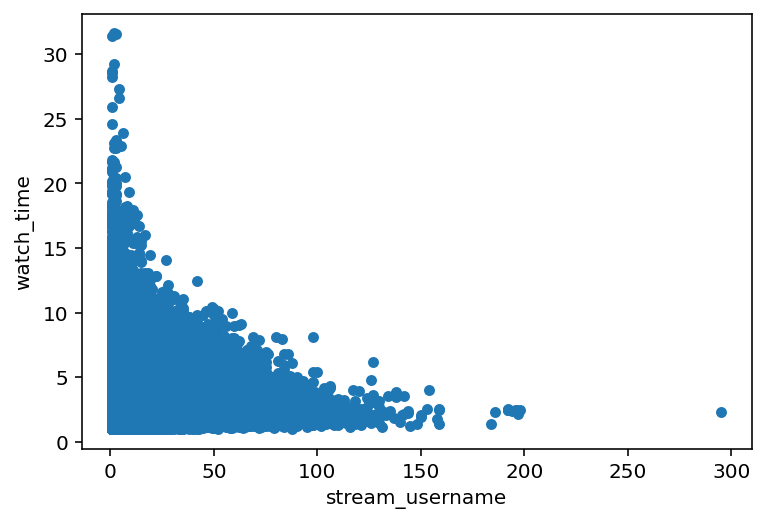

In [36]:
# average time vs streamers watched
avg_time_and_streamers = avg_watch_time.to_frame().join(count_streamers_per_user).sort_index(key=lambda i: i.astype(int))
avg_time_and_streamers.plot(kind='scatter', x='stream_username', y='watch_time')

<AxesSubplot:xlabel='user_id', ylabel='watch_time'>

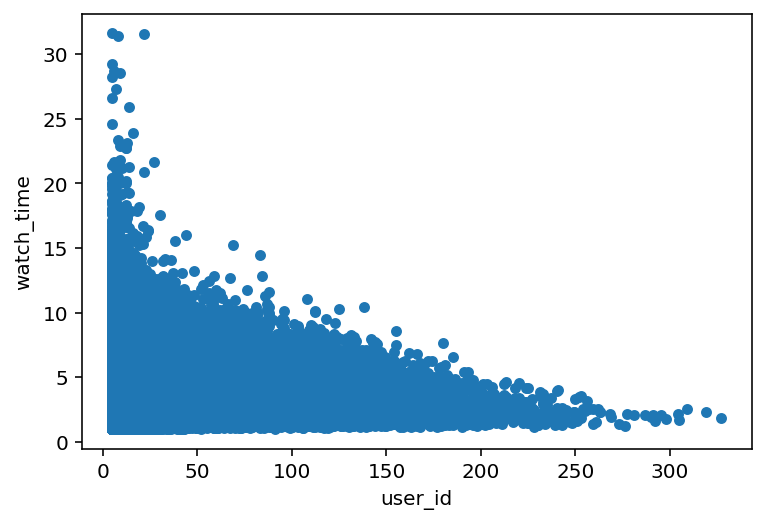

In [38]:
# average time vs streams watched
avg_time_and_streams = avg_watch_time.to_frame().join(counts_per_user).sort_index(key=lambda i: i.astype(int))
avg_time_and_streams.plot(kind='scatter', x='user_id', y='watch_time')

In [39]:
streamer_per_user = twitch_x.groupby('user_id')['stream_username'].agg(lambda s: set(s)).to_dict()

### Feature Pre-thoughts

In [ ]:
# Highly Right-skewed Data

# From the paper:
# availability
# repeated input

In [ ]:
# Popularity
# Temporal Feature
# Note: No Game Feature, Learn from interaction